In [2]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [6]:
train_audio_path = 'C:/Users/ROG/Desktop/TDL/project/speech18/'


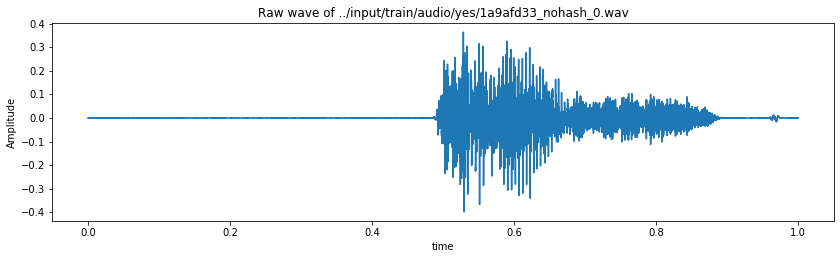

In [12]:
train_audio_path = 'C:/Users/ROG/Desktop/TDL/project/speechsmall/'
samples, sample_rate = librosa.load(train_audio_path+'yes/1a9afd33_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/1a9afd33_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
plt.show()

In [13]:
labels=os.listdir(train_audio_path)

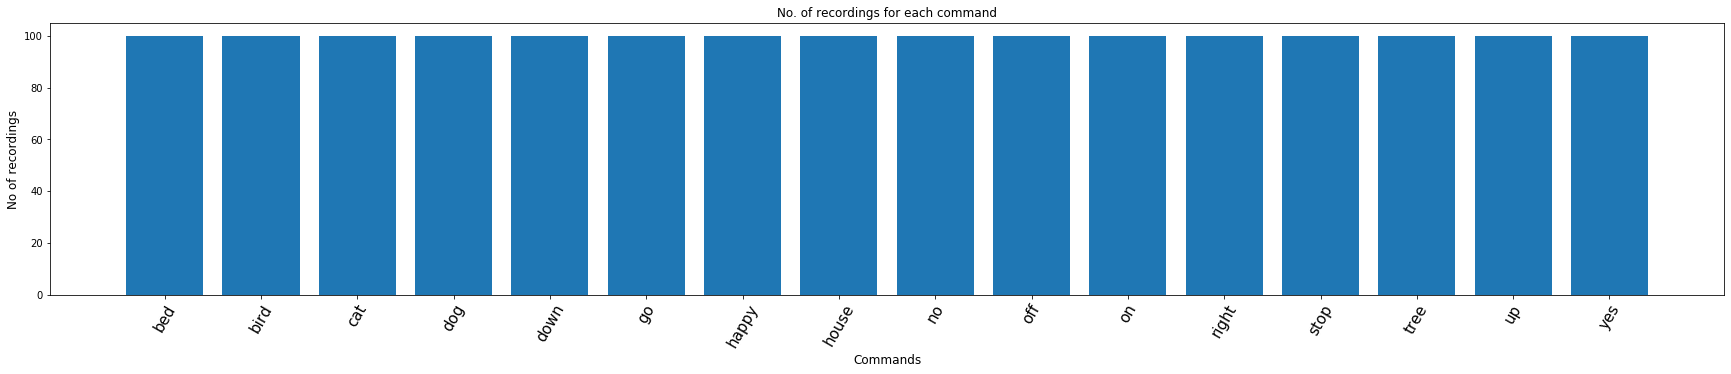

In [14]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [15]:
labels

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'go',
 'happy',
 'house',
 'no',
 'off',
 'on',
 'right',
 'stop',
 'tree',
 'up',
 'yes']

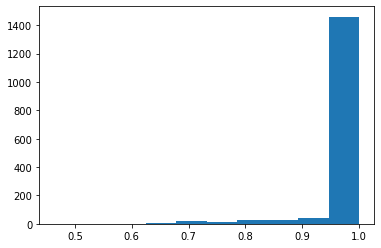

In [16]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))
plt.show()

In [17]:

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

bed
bird
cat
dog
down
go
happy
house
no
off
on
right
stop
tree
up
yes


In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [19]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [20]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [21]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [23]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

In [24]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [25]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [26]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

W1126 17:05:38.818564  2780 deprecation.py:323] From d:\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 26827 samples, validate on 6707 samples
Epoch 1/100
26816/26827 [============================>.] - ETA: 0s - loss: 2.6527 - accuracy: 0.1320

W1126 17:07:53.700773  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 134s 5ms/sample - loss: 2.6527 - accuracy: 0.1321 - val_loss: 2.5245 - val_accuracy: 0.1876
Epoch 2/100
26816/26827 [============================>.] - ETA: 0s - loss: 1.9542 - accuracy: 0.3537

W1126 17:10:11.711711  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 138s 5ms/sample - loss: 1.9540 - accuracy: 0.3538 - val_loss: 1.5038 - val_accuracy: 0.5526
Epoch 3/100
26816/26827 [============================>.] - ETA: 0s - loss: 1.4682 - accuracy: 0.5226

W1126 17:12:29.520091  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 138s 5ms/sample - loss: 1.4681 - accuracy: 0.5226 - val_loss: 1.3023 - val_accuracy: 0.5894
Epoch 4/100
26816/26827 [============================>.] - ETA: 0s - loss: 1.2338 - accuracy: 0.5994

W1126 17:14:49.618005  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 140s 5ms/sample - loss: 1.2335 - accuracy: 0.5994 - val_loss: 0.9951 - val_accuracy: 0.7023
Epoch 5/100
26816/26827 [============================>.] - ETA: 0s - loss: 1.1100 - accuracy: 0.6416

W1126 17:17:12.528737  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 143s 5ms/sample - loss: 1.1099 - accuracy: 0.6416 - val_loss: 0.8965 - val_accuracy: 0.7190
Epoch 6/100
26816/26827 [============================>.] - ETA: 0s - loss: 1.0211 - accuracy: 0.6728

W1126 17:19:26.314877  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 134s 5ms/sample - loss: 1.0209 - accuracy: 0.6728 - val_loss: 0.8140 - val_accuracy: 0.7494
Epoch 7/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.9390 - accuracy: 0.6975

W1126 17:21:39.738985  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 133s 5ms/sample - loss: 0.9394 - accuracy: 0.6975 - val_loss: 0.9574 - val_accuracy: 0.7048
Epoch 8/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.8885 - accuracy: 0.7125

W1126 17:24:03.678106  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 144s 5ms/sample - loss: 0.8886 - accuracy: 0.7125 - val_loss: 0.7600 - val_accuracy: 0.7667
Epoch 9/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.8405 - accuracy: 0.7274

W1126 17:26:13.255503  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 130s 5ms/sample - loss: 0.8405 - accuracy: 0.7274 - val_loss: 0.7241 - val_accuracy: 0.7889
Epoch 10/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.7983 - accuracy: 0.7413

W1126 17:28:25.426964  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 132s 5ms/sample - loss: 0.7984 - accuracy: 0.7413 - val_loss: 0.8635 - val_accuracy: 0.7337
Epoch 11/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.7624 - accuracy: 0.7588

W1126 17:30:36.744704  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.7625 - accuracy: 0.7587 - val_loss: 0.8543 - val_accuracy: 0.7370
Epoch 12/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.7385 - accuracy: 0.7622

W1126 17:32:49.093688  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 132s 5ms/sample - loss: 0.7383 - accuracy: 0.7623 - val_loss: 0.7155 - val_accuracy: 0.7807
Epoch 13/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.7117 - accuracy: 0.7715

W1126 17:35:01.625183  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 133s 5ms/sample - loss: 0.7118 - accuracy: 0.7714 - val_loss: 0.6708 - val_accuracy: 0.7907
Epoch 14/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.6983 - accuracy: 0.7784

W1126 17:37:14.563591  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 133s 5ms/sample - loss: 0.6981 - accuracy: 0.7785 - val_loss: 0.7334 - val_accuracy: 0.7747
Epoch 15/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.6624 - accuracy: 0.7857

W1126 17:39:27.475070  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 133s 5ms/sample - loss: 0.6623 - accuracy: 0.7857 - val_loss: 0.6220 - val_accuracy: 0.8078
Epoch 16/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.6393 - accuracy: 0.7941

W1126 17:41:39.559762  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 132s 5ms/sample - loss: 0.6391 - accuracy: 0.7942 - val_loss: 0.6155 - val_accuracy: 0.8106
Epoch 17/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.6292 - accuracy: 0.7985

W1126 17:43:52.163065  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 133s 5ms/sample - loss: 0.6291 - accuracy: 0.7985 - val_loss: 0.6643 - val_accuracy: 0.7905
Epoch 18/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.8007

W1126 17:46:04.647687  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 132s 5ms/sample - loss: 0.6168 - accuracy: 0.8007 - val_loss: 0.6648 - val_accuracy: 0.7983
Epoch 19/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.5956 - accuracy: 0.8088

W1126 17:48:18.011955  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 133s 5ms/sample - loss: 0.5957 - accuracy: 0.8087 - val_loss: 0.6320 - val_accuracy: 0.8074
Epoch 20/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.5807 - accuracy: 0.8133

W1126 17:50:29.267862  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.5807 - accuracy: 0.8132 - val_loss: 0.5742 - val_accuracy: 0.8229
Epoch 21/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.5637 - accuracy: 0.8157

W1126 17:52:40.930675  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 132s 5ms/sample - loss: 0.5637 - accuracy: 0.8157 - val_loss: 0.5793 - val_accuracy: 0.8229
Epoch 22/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.5473 - accuracy: 0.8217

W1126 17:54:51.973155  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.5477 - accuracy: 0.8216 - val_loss: 0.5538 - val_accuracy: 0.8317
Epoch 23/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.5510 - accuracy: 0.8213

W1126 17:57:03.157252  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.5510 - accuracy: 0.8213 - val_loss: 0.5893 - val_accuracy: 0.8206
Epoch 24/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.5306 - accuracy: 0.8285

W1126 17:59:14.164823  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.5304 - accuracy: 0.8285 - val_loss: 0.5963 - val_accuracy: 0.8133
Epoch 25/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.5248 - accuracy: 0.8320

W1126 18:01:24.966945  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.5247 - accuracy: 0.8320 - val_loss: 0.5376 - val_accuracy: 0.8329
Epoch 26/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.5115 - accuracy: 0.8332

W1126 18:03:35.933626  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.5115 - accuracy: 0.8332 - val_loss: 0.5619 - val_accuracy: 0.8267
Epoch 27/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4969 - accuracy: 0.8402

W1126 18:05:46.832489  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.4968 - accuracy: 0.8402 - val_loss: 0.6057 - val_accuracy: 0.8118
Epoch 28/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.5048 - accuracy: 0.8397

W1126 18:07:58.337730  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 132s 5ms/sample - loss: 0.5048 - accuracy: 0.8397 - val_loss: 0.6074 - val_accuracy: 0.8147
Epoch 29/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4797 - accuracy: 0.8436

W1126 18:10:09.358266  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.4796 - accuracy: 0.8436 - val_loss: 0.5697 - val_accuracy: 0.8251
Epoch 30/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4738 - accuracy: 0.8450

W1126 18:12:20.063648  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.4737 - accuracy: 0.8450 - val_loss: 0.5520 - val_accuracy: 0.8311
Epoch 31/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4750 - accuracy: 0.8498

W1126 18:14:32.198205  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 132s 5ms/sample - loss: 0.4750 - accuracy: 0.8498 - val_loss: 0.5944 - val_accuracy: 0.8102
Epoch 32/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4621 - accuracy: 0.8507

W1126 18:16:44.569129  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 132s 5ms/sample - loss: 0.4625 - accuracy: 0.8506 - val_loss: 0.5819 - val_accuracy: 0.8202
Epoch 33/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4589 - accuracy: 0.8531

W1126 18:18:57.295105  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 133s 5ms/sample - loss: 0.4590 - accuracy: 0.8531 - val_loss: 0.6491 - val_accuracy: 0.8013
Epoch 34/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4497 - accuracy: 0.8543

W1126 18:21:10.815955  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 134s 5ms/sample - loss: 0.4497 - accuracy: 0.8543 - val_loss: 0.5019 - val_accuracy: 0.8470
Epoch 35/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4498 - accuracy: 0.8541

W1126 18:23:23.905956  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 133s 5ms/sample - loss: 0.4498 - accuracy: 0.8541 - val_loss: 0.5695 - val_accuracy: 0.8284
Epoch 36/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4408 - accuracy: 0.8582

W1126 18:25:36.602013  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 133s 5ms/sample - loss: 0.4409 - accuracy: 0.8582 - val_loss: 0.5657 - val_accuracy: 0.8287
Epoch 37/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4300 - accuracy: 0.8608

W1126 18:27:48.011510  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.4299 - accuracy: 0.8608 - val_loss: 0.6406 - val_accuracy: 0.8047
Epoch 38/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4253 - accuracy: 0.8637

W1126 18:30:00.878110  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 133s 5ms/sample - loss: 0.4255 - accuracy: 0.8637 - val_loss: 0.5558 - val_accuracy: 0.8266
Epoch 39/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4204 - accuracy: 0.8649

W1126 18:32:12.268656  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.4203 - accuracy: 0.8649 - val_loss: 0.5554 - val_accuracy: 0.8284
Epoch 40/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4145 - accuracy: 0.8649

W1126 18:34:23.479685  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.4144 - accuracy: 0.8649 - val_loss: 0.5815 - val_accuracy: 0.8273
Epoch 41/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4228 - accuracy: 0.8638

W1126 18:36:34.985922  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 132s 5ms/sample - loss: 0.4226 - accuracy: 0.8638 - val_loss: 0.5811 - val_accuracy: 0.8223
Epoch 42/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4120 - accuracy: 0.8666

W1126 18:38:46.471215  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.4119 - accuracy: 0.8666 - val_loss: 0.5365 - val_accuracy: 0.8382
Epoch 43/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4082 - accuracy: 0.8673

W1126 18:40:57.524666  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 131s 5ms/sample - loss: 0.4082 - accuracy: 0.8673 - val_loss: 0.5802 - val_accuracy: 0.8270
Epoch 44/100
26816/26827 [============================>.] - ETA: 0s - loss: 0.4053 - accuracy: 0.8705

W1126 18:43:09.414877  2780 callbacks.py:986] Can save best model only with val_acc available, skipping.


26827/26827 [==============================] - 132s 5ms/sample - loss: 0.4053 - accuracy: 0.8705 - val_loss: 0.5621 - val_accuracy: 0.8335
Epoch 00044: early stopping


In [7]:
model.save('speechkerasmodel.h5')

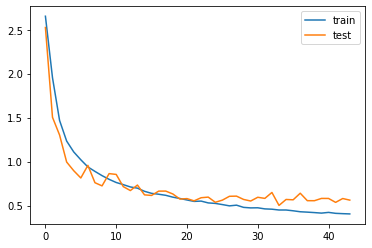

In [27]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Loading the best model**

In [1]:
from tensorflow.keras.models import load_model
model=load_model('model/speechkerasmodel.h5')

W1127 10:49:46.578579   624 deprecation.py:323] From d:\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [31]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: go


In [32]:
print("Text:",predict(samples))

Text: go


In [36]:
import sounddevice as sd
import soundfile as sf

samplerate = 8000  
duration = 1 # seconds
filename = 'recording/down_vamshi.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [37]:
#reading the voice commands
samples, sample_rate = librosa.load('recording/tree_vamshi.wav', sr = 8000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)              

In [39]:
#converting voice commands to text
predict(samples)

'up'